In [2]:
import numpy as np
from astropy.io import fits
import os, sys, shutil
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from specutils import Spectrum1D
import astropy.units as u
import astropy.constants as c
from specutils.manipulation import gaussian_smooth
from specutils.manipulation import FluxConservingResampler

In [8]:
def specToAspera(lam, flux, texp, specbin=50.*u.km/u.s, aeff=0.75*u.cm**2,
                 respower=1500.):
    
    
    """
    Function to generate an Aspera mock spectrum from an original FUSE spectrum.  
    
    The following steps are executed:
    1. Convolution to requested spectral resolution 
    2. Spectral rebinning on requested velocity bin size. To convert velocity to
        wavelength, a reference wavelength of 1035 AA is assumed. 
    3. Convert flux units to counts, considering requested exposure time and
        effective area. 
    

    Parameters
    ----------
    lam: 1D array
        Wavelength array of FUSE spectrum, assuming units in AA
    flux: 1D array
        Flux array of FUSE spectrum, assuming units in erg/s/cm**2/AA
    texp: float
        Requested exposure time, assuming units in s
    specbin: astropy Quantity (velocity)
        Requested velocity bin size the output spectrum will be resampled at. 
        Default value: 50 km/s
    aeff: astropy Quantity (area)
        Requested effective area to be used to transform flux to counts spectrum. 
        Default value: 0.75 cm^2
    respower: float
        Requested resolving power the input spectrum will be convolved to. 
        Default value: 1500

    Returns
    -------
    
    lam_new: 1D array
        Output wavelength array, assuming units of AA
    counts: 1D array
        Output counts array, assuming units of counts

    """ 
    
    
    # Create Spectrum1D objects
    spec = Spectrum1D(spectral_axis=lam*u.AA, 
                      flux=flux*u.erg/u.s/u.cm**2/u.AA)
    
    # Convolve to R=respower
    std_AA = 1035*u.AA/respower/(2.*np.sqrt(2.*np.log(2)))
    stddev_px = (std_AA/np.mean(np.diff(lam*u.AA))).decompose().value
    spec_smooth = gaussian_smooth(spec, stddev=stddev_px) 
    print('Requested sigma [AA], requ. sigma [px], FUSE intrinsice bin size [AA]', std_AA, stddev_px, np.diff(lam)[0])
    
    # Rebin on 50 km/s grid
    dlam_new = ((specbin/c.c)*1035*u.AA).to(u.AA).value
    lam_new = np.arange(lam[0], lam[-1], step=dlam_new)*u.AA
    fluxc_resample = FluxConservingResampler()  
    spec_rebinned = fluxc_resample(spec_smooth, lam_new)
    
    # Convert to counts
    energy = c.h*c.c/lam_new 
    dlam = dlam_new*u.AA
    counts = (spec_rebinned.flux/energy*texp*aeff*dlam).decompose()
    
    return lam_new.value, counts 
    

In [7]:
path_root = '/Users/kepplerm/Documents/Work/Data/FUSE/calibration_data/'
#folders = ['flux_calib', 'wavelength_calib']
#programs = ['M101','M112', 'M103', 'M105']

# Original FUSE spectra

## Flux calibration targets

GD246
GD153
G191-B2B
HZ43
GD659
GD71


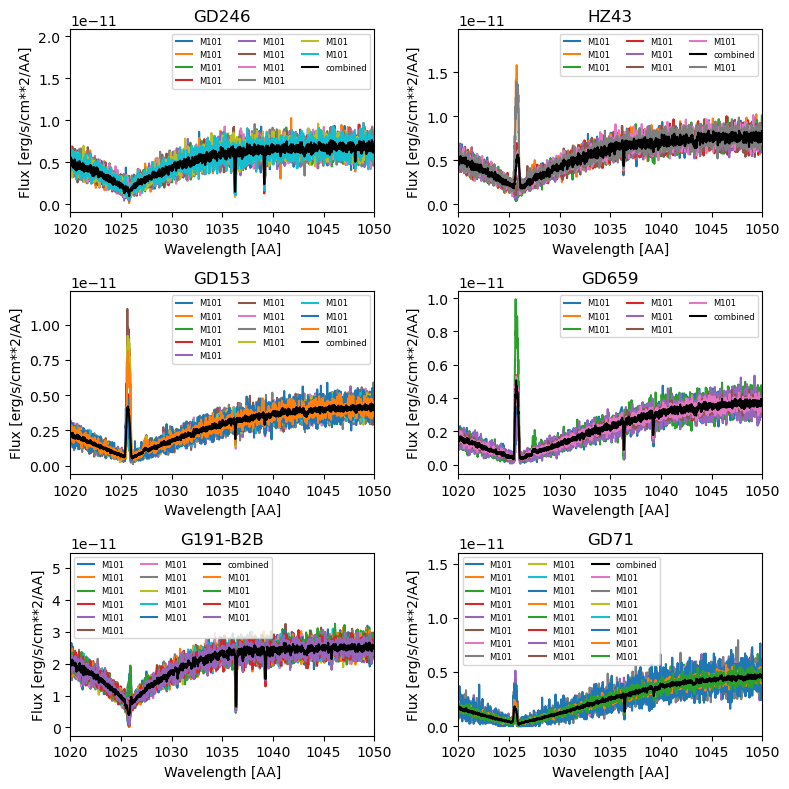

In [36]:
folders = ['flux_calib', ]
programs = ['M101',]

fig, ax = plt.subplots(3, 2, figsize=(8, 8))

m = 0 

for folder in folders:
    path = path_root+folder
    targets = os.listdir(path)
    if '.DS_Store' in targets:
        targets.remove('.DS_Store')
        
    
    for i in range(0, len(targets)):
        target = targets[i]
        
        if target != 'ALPHA-TRA':
            print(target) 
            
            files = os.listdir(path+'/'+target+'/')
            
            k=0
            for j in range(0, len(files)):
                
                file = files[j] 
                
                if file.endswith('1alif4histfcal.fit') or file.endswith('1alif4ttagfcal.fit') or file.endswith('combined.fit'):
                
                    
                    file = files[j]
                    
                    if file != 'M10104020071alif4ttagfcal.fit': # This is a file with mispointing
                        
                        dat = fits.open(path+'/'+target+'/'+file)
                        
                        
                        datobs = dat[0].header['DATEOBS']
                        prgmid = dat[0].header['PRGRM_ID']
                        
                        # Use only obs from program M101
                        if prgmid in programs:
                            
                            # Copy to transfer foleder
                            #if not os.path.exists('/Users/kepplerm/transfer/'+target):
                            #    os.makedirs('/Users/kepplerm/transfer/'+target) 
                            #shutil.copy(path+'/'+target+'/'+file,'/Users/kepplerm/transfer/'+target+'/')
                            
                            targname = dat[0].header['TARGNAME']
                            if targname != target:
                                print('Target mismatch! '+target+' '+targname)
                                
                            expstat = dat[0].header['EXP_STAT']    
                                
                            lam = np.squeeze(dat[1].data['WAVE'])
                            flux = np.squeeze(dat[1].data['FLUX'])
                            
                            fluxtot = np.nansum(flux[(lam>1020)&(lam<1050)])
                            
                            # Convolution
                            #flux = nd.gaussian_filter(flux, 10)
                            
                            if m < 3:
                                ind2 = 0
                                ind1 = m
                            if m >= 3:
                                ind2 = 1
                                ind1 = m-3
                                
                            
                            if k == 0: 
                                ax[ind1, ind2].set_title(target)
                                
                            if file.endswith('combined.fit'):
                                ax[ind1, ind2].plot(lam, flux, label='combined', 
                                                    c='k', zorder=100) 
                            
                            else:
                                ax[ind1, ind2].plot(lam, flux, label=prgmid) 
                           
                            k=k+1
                            ax[ind1, ind2].legend(ncols=3, fontsize=6)
                            ax[ind1, ind2].set_xlim(1020, 1050)
                            ax[ind1, ind2].set_xlabel('Wavelength [AA]')
                            ax[ind1, ind2].set_ylabel('Flux [erg/s/cm**2/AA]')
            m = m+1
plt.tight_layout()
plt.savefig('flux_targets_M101.png')
plt.show()

## Spectral calibration targets

M97
Target mismatch! M97 NGC3587
Target mismatch! M97 NGC3587
Target mismatch! M97 NGC3587
Target mismatch! M97 NGC3587
Target mismatch! M97 NGC3587
GCRV12336


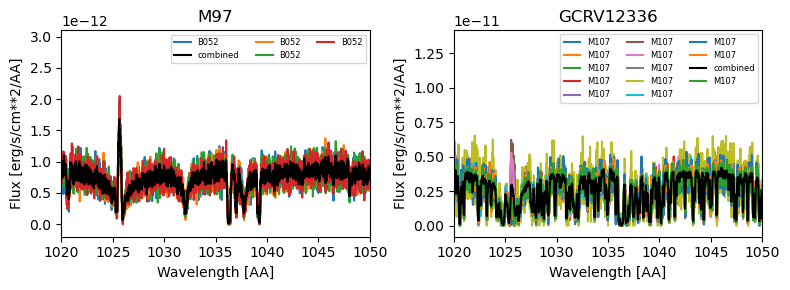

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

m = 0 

programs = ['M107','B052']

for folder in ['wavelength_calib']:
    path = path_root+'wavelength_calib'
    targets = os.listdir(path)
    if '.DS_Store' in targets:
        targets.remove('.DS_Store')
        
    for i in range(0, len(targets)):
        target = targets[i]
        
        if target not in ['ALPHA-TRA', 'GD984', 'WD0005+511', 'WD0439+466']:
            print(target) 
            
            files = os.listdir(path+'/'+target+'/')
            
            k=0
            for j in range(0, len(files)):
                
                file = files[j] 
                
                if file.endswith('1alif4histfcal.fit') or file.endswith('1alif4ttagfcal.fit') or file.endswith('combined.fit'):
                    
                    if file != 'M10703120061alif4ttagfcal.fit': # This is a file with mispointing
                        
                        dat = fits.open(path+'/'+target+'/'+file)
                        
                        # Copy to transfer foleder
                        #if not os.path.exists('/Users/kepplerm/transfer/'+target):
                        #    os.makedirs('/Users/kepplerm/transfer/'+target) 
                        #shutil.copy(path+'/'+target+'/'+file,'/Users/kepplerm/transfer/'+target+'/')
                        
                        datobs = dat[0].header['DATEOBS']
                        prgmid = dat[0].header['PRGRM_ID']
                        
                        # Use only obs from program M101
                        if prgmid in programs:
                        
                            targname = dat[0].header['TARGNAME']
                            if targname != target:
                                print('Target mismatch! '+target+' '+targname)
                            lam = np.squeeze(dat[1].data['WAVE'])
                            flux = np.squeeze(dat[1].data['FLUX'])
                            
                            # Convolution
                            #flux = nd.gaussian_filter(flux, 10)
                            
                            if k == 0: 
                                ax[m].set_title(target)
                                
                            if file.endswith('combined.fit'):
                                ax[m].plot(lam, flux, label='combined', 
                                                    c='k', zorder=100) 
                            
                            else:
                                ax[m].plot(lam, flux, label=prgmid) 
                            
                            k=k+1
                            ax[m].legend(ncols=3, fontsize=6)
                            ax[m].set_xlim(1020, 1050)
                            ax[m].set_xlabel('Wavelength [AA]')
                            ax[m].set_ylabel('Flux [erg/s/cm**2/AA]')
            m = m+1
plt.tight_layout()
#plt.savefig('wave_targets_smoothed.png')
plt.savefig('wave_targets.png')

plt.show()

M97
B052
Target mismatch! M97 NGC3587
B052
Target mismatch! M97 NGC3587
B052
Target mismatch! M97 NGC3587
B052
Target mismatch! M97 NGC3587
B052
Target mismatch! M97 NGC3587
GCRV12336
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
WD0005+511
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
WD0439+466
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107
M107


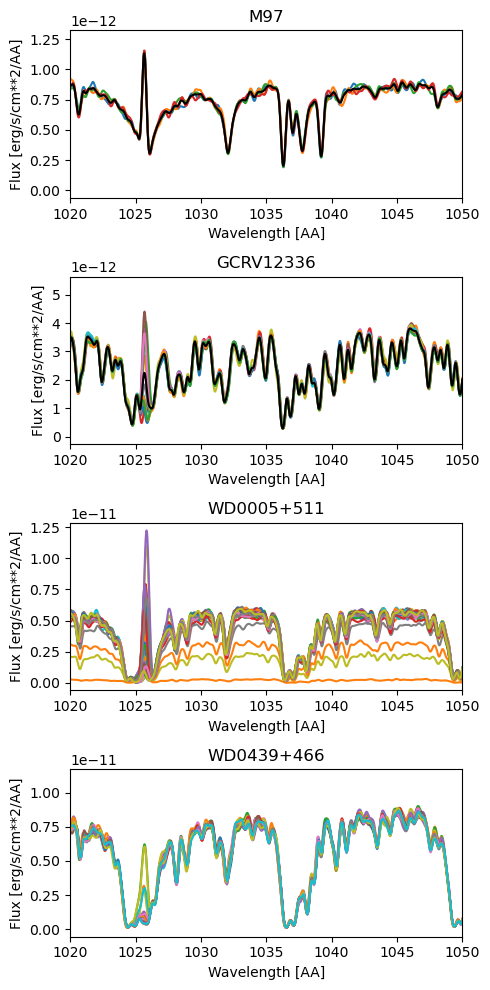

In [77]:
fig, ax = plt.subplots(4, 1, figsize=(5, 10))

m = 0 

programs = ['M107','B052']

for folder in ['wavelength_calib']:
    path = path_root+'wavelength_calib'
    targets = os.listdir(path)
    if '.DS_Store' in targets:
        targets.remove('.DS_Store')
        
    
    for i in range(0, len(targets)):
        target = targets[i]
        
        if target not in ['ALPHA-TRA', 'GD984']:
            print(target) 
            
            files = os.listdir(path+'/'+target+'/')
            
            k=0
            for j in range(0, len(files)):
                
                file = files[j] 
                
                if file.endswith('1alif4histfcal.fit') or file.endswith('1alif4ttagfcal.fit') or file.endswith('combined.fit'):
                    
                    if file != 'M10703120061alif4ttagfcal.fit': # This is a file with mispointing
                        
                        dat = fits.open(path+'/'+target+'/'+file)
                        
                        # Copy to transfer foleder
                        #if not os.path.exists('/Users/kepplerm/transfer/'+target):
                        #    os.makedirs('/Users/kepplerm/transfer/'+target) 
                        #shutil.copy(path+'/'+target+'/'+file,'/Users/kepplerm/transfer/'+target+'/')
                        
                        datobs = dat[0].header['DATEOBS']
                        prgmid = dat[0].header['PRGRM_ID']
                        print(prgmid)
                        
                        # Use only obs from program M101
                        if prgmid in programs:
                        
                            targname = dat[0].header['TARGNAME']
                            if targname != target:
                                print('Target mismatch! '+target+' '+targname)
                            lam = np.squeeze(dat[1].data['WAVE'])
                            flux = np.squeeze(dat[1].data['FLUX'])
                            
                            # Convolution
                            flux = nd.gaussian_filter(flux, 10)
                            
                            if k == 0: 
                                ax[m].set_title(target)
                                
                            if file.endswith('combined.fit'):
                                ax[m].plot(lam, flux, label='combined', 
                                                    c='k', zorder=100) 
                            
                            else:
                                ax[m].plot(lam, flux, label=prgmid) 
                            
                            k=k+1
                            #ax[m].legend(ncols=3, fontsize=6)
                            ax[m].set_xlim(1020, 1050)
                            ax[m].set_xlabel('Wavelength [AA]')
                            ax[m].set_ylabel('Flux [erg/s/cm**2/AA]')
            m = m+1
plt.tight_layout()
#plt.savefig('wave_targets_smoothed.png')
plt.show()

# Convert Flux to count rates

Target mismatch! M97 NGC3587


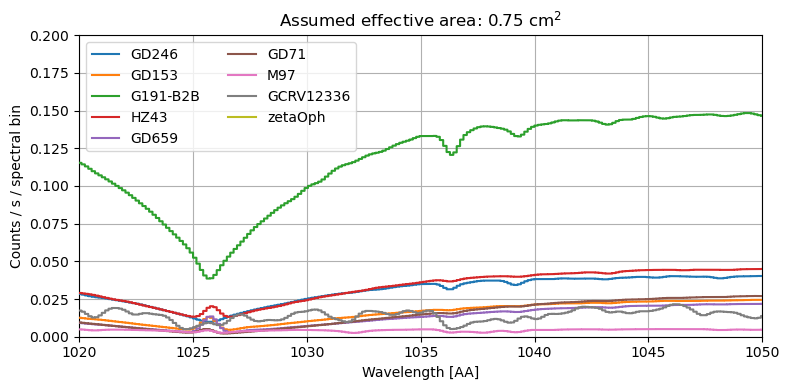

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

m = 0 
targets = ['GD246','GD153','G191-B2B','HZ43','GD659','GD71', 'M97', 'GCRV12336', 'zetaOph']
folders = ['flux_calib','flux_calib','flux_calib','flux_calib','flux_calib','flux_calib',
           'wavelength_calib','wavelength_calib', 'wavelength_calib']
texp_arr = [1, 1, 1, 1, 1, 1, 1, 1,1]     
aeff = 0.75*u.cm**2
    
for i in range(0, len(targets)):
    target = targets[i]
    texp = texp_arr[i]
    
    if target == 'zetaOph':
        flux = np.ones(len(lam))*0.3e-8#*u.erg/u.s/u.cm**2/u.AA
    
    else:
        path = path_root+folders[i]
        files = path+'/'+target+'/'+target+'_combined.fit'
        dat = fits.open(files)
        datobs = dat[0].header['DATEOBS']
        targname = dat[0].header['TARGNAME']
        expstat = dat[0].header['EXP_STAT']    
    
        if targname != target:
            print('Target mismatch! '+target+' '+targname)
            
        lam = np.squeeze(dat[1].data['WAVE'])
        flux = np.squeeze(dat[1].data['FLUX'])
    
    fluxtot = np.nansum(flux[(lam>1020)&(lam<1050)])
        
    lamAspera, fluxAspera = specToAspera(lam, flux, texp, specbin=43*u.km/u.s, 
                                        aeff=aeff)
        
    ax.step(lamAspera, fluxAspera,  zorder=100, where='mid', label=target)
                             
    
    ax.set_xlim(1020, 1050)
    ax.set_xlabel('Wavelength [AA]')
    ax.set_ylabel('Counts / s / spectral bin')
        
ax.legend(ncols=2)
#ax.set_yscale('log')
ax.set_ylim(0, 0.2)
plt.title(r'Assumed effective area: '+str(aeff.value)+' cm$^2$')
plt.tight_layout()
plt.grid(True)
plt.savefig('count_rates_aeff'+str(aeff)+'cm2_lin.png')
plt.show()

# Convert flux to counts

Target mismatch! M97 NGC3587


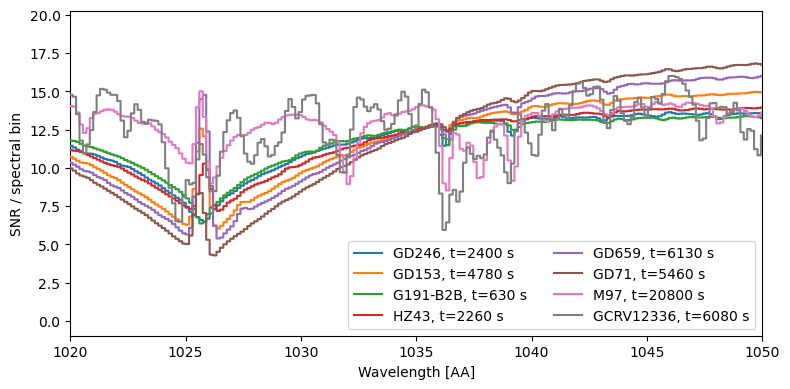

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

targets = ['GD246','GD153','G191-B2B','HZ43','GD659','GD71', 'M97', 'GCRV12336', 'zetaOph']
folders = ['flux_calib','flux_calib','flux_calib','flux_calib','flux_calib','flux_calib',
           'wavelength_calib','wavelength_calib', 'wavelength_calib']
texp_arr = [2400, 4780, 630, 2260, 6130, 5460, 20800, 6080, 4.6]

mode = 'SNR'
#mode = 'counts'

for i in range(0, len(targets)-1):
    target = targets[i]
    path = path_root+folders[i]
    texp = texp_arr[i]
    
    if target == 'zetaOph':
        flux = np.ones(len(lam))*0.3e-8#*u.erg/u.s/u.cm**2/u.AA
    
    else:
        path = path_root+folders[i]
        files = path+'/'+target+'/'+target+'_combined.fit'
        dat = fits.open(files)
        datobs = dat[0].header['DATEOBS']
        targname = dat[0].header['TARGNAME']
        expstat = dat[0].header['EXP_STAT']    
    
        if targname != target:
            print('Target mismatch! '+target+' '+targname)
            
        lam = np.squeeze(dat[1].data['WAVE'])
        flux = np.squeeze(dat[1].data['FLUX'])
    
    
    lamAspera, fluxAspera = specToAspera(lam, flux, texp, specbin=43*u.km/u.s,
                                         aeff=1.43*u.cm**2,
                                         respower=2654) # corresponding to CBE
    
    snr = np.sqrt(np.nansum(fluxAspera[(lamAspera>=1030)&(lamAspera<=1040)]))
    isnr = np.around(snr.value, 2)
        
    if mode == 'counts':
        ax.step(lamAspera, fluxAspera,  zorder=100, where='mid', 
            label=r''+target+', t='+str(texp)+' s, $\mathrm{iSNR}_{3040}$='+str(isnr))
        ax.set_ylabel('Counts / spectral bin')
        ax.axhline(25, color='gray',ls=':')
    if mode == 'SNR':
        ax.step(lamAspera, np.sqrt(fluxAspera),  zorder=100, where='mid', 
            label=r''+target+', t='+str(texp)+' s')
        ax.set_ylabel('SNR / spectral bin')
                             
    
    ax.set_xlim(1020, 1050)
    ax.set_xlabel('Wavelength [AA]')
        
ax.legend(ncols=2)
plt.tight_layout()
#plt.savefig('counts_spectra.png')
plt.grid(False)
plt.savefig('SNR_spectra_nozetaoph_CBE.png')
plt.show()

# Convert flux to counts per resolution element

Target mismatch! M97 NGC3587


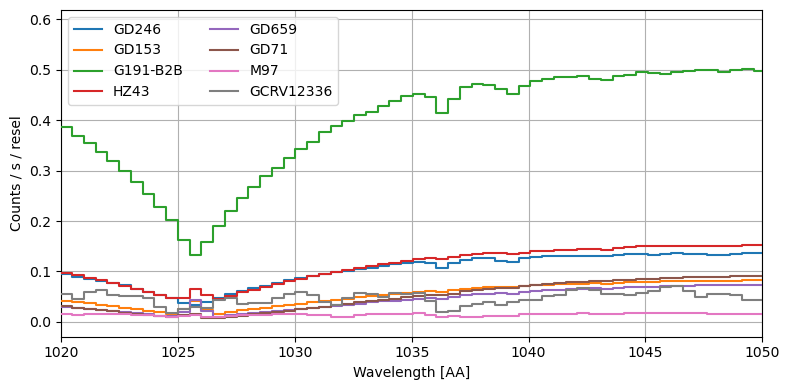

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

targets = ['GD246','GD153','G191-B2B','HZ43','GD659','GD71', 'M97', 'GCRV12336',]#  'zetaOph']
folders = ['flux_calib','flux_calib','flux_calib','flux_calib','flux_calib','flux_calib',
           'wavelength_calib','wavelength_calib','wavelength_calib' ]
texp_arr = [1, 1, 1, 1, 1, 1, 1, 1, 1]     
    
for i in range(0, len(targets)):
    target = targets[i]
    path = path_root+folders[i]
    texp = texp_arr[i]
    
    if target == 'zetaOph':
        flux = np.ones(len(lam))*0.3e-8#*u.erg/u.s/u.cm**2/u.AA
    
    else:
        path = path_root+folders[i]
        files = path+'/'+target+'/'+target+'_combined.fit'
        dat = fits.open(files)
        datobs = dat[0].header['DATEOBS']
        targname = dat[0].header['TARGNAME']
        expstat = dat[0].header['EXP_STAT']    
    
        if targname != target:
            print('Target mismatch! '+target+' '+targname)
            
        lam = np.squeeze(dat[1].data['WAVE'])
        flux = np.squeeze(dat[1].data['FLUX'])
    
    fluxtot = np.nansum(flux[(lam>1020)&(lam<1050)])
        
    lamAspera, fluxAspera = specToAspera(lam, flux, texp, specbin=145.7*u.km/u.s)
        
    ax.step(lamAspera, fluxAspera,  zorder=100, where='mid', label=target)
                             
    
    ax.set_xlim(1020, 1050)
    ax.set_xlabel('Wavelength [AA]')
    ax.set_ylabel('Counts / s / resel')
        
ax.legend(ncols=2)
plt.tight_layout()
plt.grid(True)
#plt.savefig('count_rate_resel_zetaOph.png')
plt.savefig('count_rate_resel.png')
plt.show()